In [87]:
%load_ext autoreload
%autoreload 2

from codes.Kalman import *
from scipy.integrate import odeint
from sklearn.linear_model import LinearRegression
import random

%pylab inline
%matplotlib inline
pylab.rcParams['figure.figsize'] = (16, 9)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Populating the interactive namespace from numpy and matplotlib


/home/administrateur/anaconda3/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


### Important parameters

In [88]:
# index of the unobserved component
i_unobs_comp = 0

# integration time step
dt = 0.001

# variance of the random white noise of z
variance_unobs_comp = 5

# variance of the observation error used in Kalman
variance_obs_comp = 0.0001

# number of Lorenz-63 times
nb_loop = 10

# number of SEM iterations
nb_iter_SEM = 30

### Generate simulated data

In [89]:
# Lorenz-63 dynamical model
def Lorenz_63(x, dx, sigma, rho, beta):
    dx = zeros((3))
    dx[0] = sigma*(x[1]-x[0])
    dx[1] = x[0]*(rho-x[2])-x[1]
    dx[2] = x[0]*x[1] - beta*x[2]
    return dx

# Lorenz-63 parameters
x0 = array([8, 0, 30]) # initial condition
sigma = 10; rho = 28; beta = 8/3 # physical parameters

# time and truth
t   = arange(0.01, nb_loop, dt)
x_t = odeint(Lorenz_63, x0, arange(0.01, nb_loop, dt), args=(sigma, rho, beta))

# observations
y = x_t.copy()
y = delete(y, i_unobs_comp, axis=1)

# add noise to the observations
# y = y + random.multivariate_normal(array([0, 0]), variance_obs_comp*eye(shape(y)[1]), size=shape(y)[0])

### V0: $x = [x_2, x_3]$

In [90]:
# state
x = c_[y[:,0], y[:,1]]

# shapes
n = shape(x)[1]
p = shape(y)[1]

# kalman parameters
H = eye(n)
R = variance_obs_comp*eye(p)

# stochastic EM
x_s_V0, P_s_V0, M_V0, loglik_V0, x, x_f_V0, Q_V0 = Kalman_SEM(x, y, H, R, nb_iter_SEM)

100%|██████████| 30/30 [00:51<00:00,  1.71s/it]


### V1: $x = [x_2, x_3, z_1]$

In [91]:
# state
z = random.normal(loc=x_t[:,i_unobs_comp]*0, scale=variance_unobs_comp, size=shape(y)[0])
x = c_[y[:,0], y[:,1], z]

# shapes
n = shape(x)[1]
p = shape(y)[1]

(0.01, 9.998999999999992)

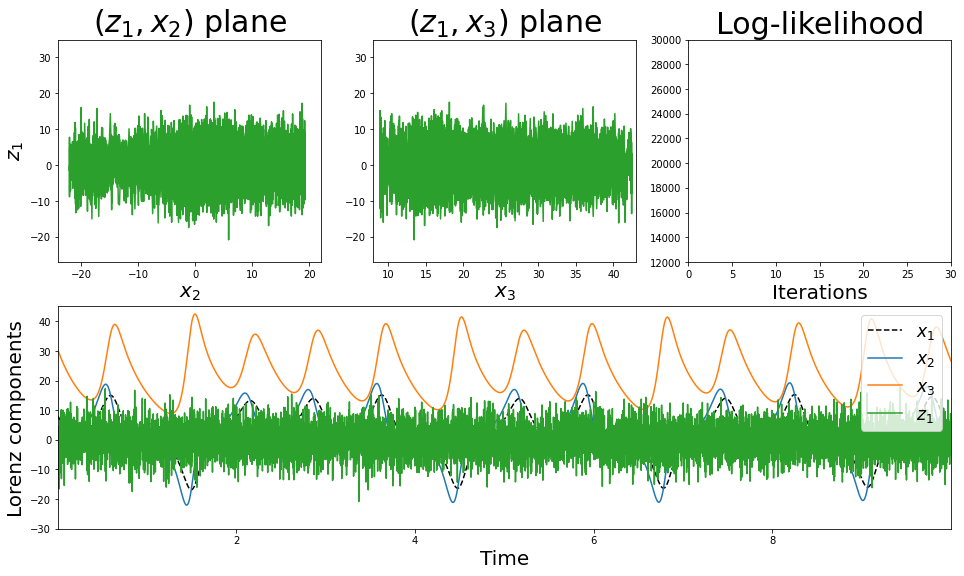

In [6]:
# plot
figure()
i_unobs_comp=0
subplot(2,3,1)
plot(x[:,0], x[:,2], 'C2')
#plot(x_t[:,1], x_t[:,0], 'k--')
title('$(z_1, x_2)$ plane', size=30)
xlabel('$x_2$', size=20)
ylabel('$z_1$', size=20)
xlim([-24,22])
ylim([-27,35])
subplot(2,3,2)
plot(x[:,1], x[:,2], 'C2')
#plot(x_t[:,2], x_t[:,0], 'k--')
title('$(z_1, x_3)$ plane', size=30)
xlabel('$x_3$', size=20)
#ylabel('$z_1$', size=20)
xlim([8,43])
ylim([-27,35])
subplot(2,3,3)
plot(loglik_V0[1:]*0, 'C2')
#plot(loglik_V0[1:], '--k')
title('Log-likelihood', size=30)
xlabel('Iterations', size=20)
xlim([0,30])
ylim([12000,30000])
subplot(2,3,(4,6))
# true components
tab_labels = ['$x_1$', '$x_2$', '$x_3$', '$z_1$']
plot(t, x_t[:,i_unobs_comp], '--k')
plot(t, x_t[:,1], color='C0')
plot(t, x_t[:,2], color='C1')
plot(t, x[:,2], color='C2')
legend(tab_labels, loc=1, fontsize='xx-large')
ylim([-30,45])
xlim([t[0],t[-1]])
#fill_between(t, x_s[:,2]-1.96*sqrt(P_s[:,2,2]), x_s[:,2]+1.96*sqrt(P_s[:,2,2]), facecolor='C2', alpha=0.25)
xlabel('Time', size=20)
ylabel('Lorenz components', size=20)
ylim([-30,45])
xlim([t[0],t[-1]])
#savefig('/home/administrateur/Dropbox/Applications/Overleaf/presentation_buenos_aires_2023_02_10/L63_000.png', bbox_inches='tight', dpi=50)

### Comparison of the likelihoods

In [92]:
random.seed(0)

z_V1 = random.normal(loc=x_t[:,i_unobs_comp]*0, scale=variance_unobs_comp, size=shape(y)[0])
z_V2 = random.normal(loc=x_t[:,i_unobs_comp]*0, scale=variance_unobs_comp, size=shape(y)[0])
z_V3 = random.normal(loc=x_t[:,i_unobs_comp]*0, scale=variance_unobs_comp, size=shape(y)[0])

# state
x = c_[y[:,0], y[:,1], z_V1]

# shapes
n = shape(x)[1]
p = shape(y)[1]

# kalman parameters
H = delete(eye(n), 2, axis=0)
R = variance_obs_comp*eye(p)

# stochastic EM
x_s_V1, P_s_V1, M_V1, loglik_V1, x, x_f_V1, Q_V1 = Kalman_SEM(x, y, H, R, nb_iter_SEM)

# state
x = c_[x, z_V2]

# shapes
n = shape(x)[1]
p = shape(y)[1]

# kalman parameters
H = delete(eye(n), [2,3], axis=0)
R = variance_obs_comp*eye(p)

# stochastic EM
x_s_V2, P_s_V2, M_V2, loglik_V2, x, x_f_V2, Q_V2 = Kalman_SEM(x, y, H, R, nb_iter_SEM)

# state
x = c_[x, z_V3]

# shapes
n = shape(x)[1]
p = shape(y)[1]

# kalman parameters
H = delete(eye(n), [2,3,4], axis=0)
R = variance_obs_comp*eye(p)

# stochastic EM
x_s_V3, P_s_V3, M_V3, loglik_V3, x, x_f_V3, Q_V3 = Kalman_SEM(x, y, H, R, nb_iter_SEM)

100%|██████████| 30/30 [01:00<00:00,  2.02s/it]


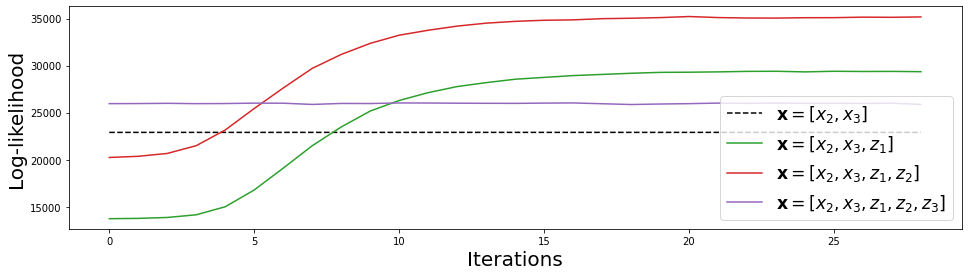

In [13]:
# likelihood
subplot(2,1,1)
plot(loglik_V0[1:], '--k')
plot(loglik_V1[1:], color='C2')
plot(loglik_V2[1:], color='C3')
plot(loglik_V3[1:], color='C4')
xlabel('Iterations', size=20)
ylabel('Log-likelihood', size=20)
legend(['$\mathbf{x} = [x_2, x_3]$', '$\mathbf{x} = [x_2, x_3, z_1]$', '$\mathbf{x} = [x_2, x_3, z_1, z_2]$', '$\mathbf{x} = [x_2, x_3, z_1, z_2, z_3]$'],
       loc=0, fontsize='xx-large')
#savefig('/home/administrateur/Dropbox/Applications/Overleaf/presentation_buenos_aires_2023_02_10/L63_comp_lik.png', bbox_inches='tight', dpi=400)

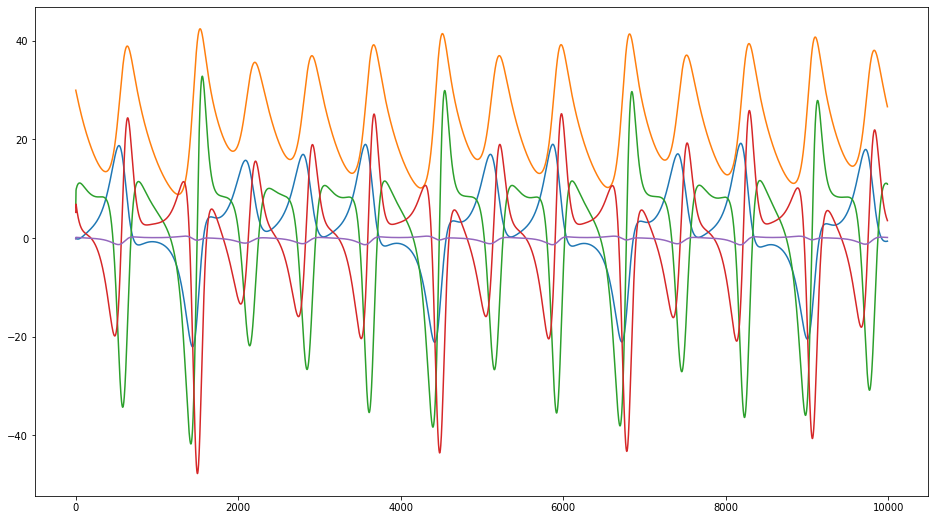

In [14]:
plot(x_s_V3)

### Metric as a function of the lead time

In [93]:
def RMSE(x_for, x_true):
    return sqrt(mean((x_for-x_true)**2))
def cov_prob(x_for, P_for, x_true):
    sum = 0
    for k in range(len(x_for)):
        sum += (x_true[k] >= x_for[k] - 0.64 * sqrt(P_for[k])) and (x_true[k] <= x_for[k] + 0.64 * sqrt(P_for[k]))
    return sum/len(x_for)    

In [94]:
# test dataset
x_test = odeint(Lorenz_63, x_t[-1,:], arange(0.01, nb_loop, dt), args=(sigma, rho, beta))
y_test = x_test.copy()
y_test = delete(y_test, i_unobs_comp, axis=1)

# apply filter on the test dataset
H = eye(2)
x_for_V0, P_for_V0, tej1, tej2, x_s_V0, P_s_V0, tej5, tej6 = Kalman_smoother(y_test, x_s_V0[-1,:], P_s_V0[-1,:,:,], M_V0, Q_V0, H, R)
H = delete(eye(3), 2, axis=0)
x_for_V1, P_for_V1, tej1, tej2, x_s_V1, P_s_V1, tej5, tej6 = Kalman_smoother(y_test, x_s_V1[-1,:], P_s_V1[-1,:,:,], M_V1, Q_V1, H, R)
H = delete(eye(4), [2,3], axis=0)
x_for_V2, P_for_V2, tej1, tej2, x_s_V2, P_s_V2, tej5, tej6 = Kalman_smoother(y_test, x_s_V2[-1,:], P_s_V2[-1,:,:,], M_V2, Q_V2, H, R)
H = delete(eye(5), [2,3,4], axis=0)
x_for_V3, P_for_V3, tej1, tej2, x_s_V3, P_s_V3, tej5, tej6 = Kalman_smoother(y_test, x_s_V3[-1,:], P_s_V3[-1,:,:,], M_V3, Q_V3, H, R)

In [95]:
# max horizon
horizon = 500

# initialization
x_true   = zeros((len(x_test)-horizon, horizon, shape(x_test)[1]))
x_for_V0 = zeros((len(x_test)-horizon, horizon, shape(x_s_V0)[1]))
x_for_V1 = zeros((len(x_test)-horizon, horizon, shape(x_s_V1)[1]))
x_for_V2 = zeros((len(x_test)-horizon, horizon, shape(x_s_V2)[1]))
x_for_V3 = zeros((len(x_test)-horizon, horizon, shape(x_s_V3)[1]))
P_for_V0 = zeros((len(x_test)-horizon, horizon, shape(Q_V0)[0], shape(Q_V0)[1]))
P_for_V1 = zeros((len(x_test)-horizon, horizon, shape(Q_V1)[0], shape(Q_V1)[1]))
P_for_V2 = zeros((len(x_test)-horizon, horizon, shape(Q_V2)[0], shape(Q_V2)[1]))
P_for_V3 = zeros((len(x_test)-horizon, horizon, shape(Q_V3)[0], shape(Q_V3)[1]))

# loop on time steps
for k in range(len(x_t)-horizon):
    x_true[k,0,:] = x_test[k,:]
    x_for_V0[k,0,:] = x_s_V0[k,:]
    x_for_V1[k,0,:] = x_s_V1[k,:]
    x_for_V2[k,0,:] = x_s_V2[k,:]
    x_for_V3[k,0,:] = x_s_V3[k,:]
    P_for_V0[k,0,:,:] = P_s_V0[k,:,:]
    P_for_V1[k,0,:,:] = P_s_V1[k,:,:]
    P_for_V2[k,0,:,:] = P_s_V2[k,:,:]
    P_for_V3[k,0,:,:] = P_s_V3[k,:,:]
    # loop on horizons
    for h in range(horizon-1):
        x_true[k,h+1,:] = x_test[k+h+1,:]
        x_for_V0[k,h+1,:] = M_V0 @ x_for_V0[k,h,:]
        x_for_V1[k,h+1,:] = M_V1 @ x_for_V1[k,h,:]
        x_for_V2[k,h+1,:] = M_V2 @ x_for_V2[k,h,:]
        x_for_V3[k,h+1,:] = M_V3 @ x_for_V3[k,h,:]
        P_for_V0[k,h+1,:,:] = M_V0 @ P_for_V0[k,h,:,:] @ M_V0.T + Q_V0
        P_for_V1[k,h+1,:,:] = M_V1 @ P_for_V1[k,h,:,:] @ M_V1.T + Q_V1
        P_for_V2[k,h+1,:,:] = M_V2 @ P_for_V2[k,h,:,:] @ M_V2.T + Q_V2
        P_for_V3[k,h+1,:,:] = M_V3 @ P_for_V3[k,h,:,:] @ M_V3.T + Q_V3

In [96]:
# initialization
tab_RMSE_V0_x2 = zeros((horizon))
tab_RMSE_V1_x2 = zeros((horizon))
tab_RMSE_V2_x2 = zeros((horizon))
tab_RMSE_V3_x2 = zeros((horizon))
tab_RMSE_V0_x3 = zeros((horizon))
tab_RMSE_V1_x3 = zeros((horizon))
tab_RMSE_V2_x3 = zeros((horizon))
tab_RMSE_V3_x3 = zeros((horizon))

# loop on horizons
for h in range(horizon):
    tab_RMSE_V0_x2[h] = RMSE(x_for_V0[:,h,0], x_true[:,h,1])
    tab_RMSE_V1_x2[h] = RMSE(x_for_V1[:,h,0], x_true[:,h,1])
    tab_RMSE_V2_x2[h] = RMSE(x_for_V2[:,h,0], x_true[:,h,1])
    tab_RMSE_V3_x2[h] = RMSE(x_for_V3[:,h,0], x_true[:,h,1])
    tab_RMSE_V0_x3[h] = RMSE(x_for_V0[:,h,1], x_true[:,h,2])
    tab_RMSE_V1_x3[h] = RMSE(x_for_V1[:,h,1], x_true[:,h,2])
    tab_RMSE_V2_x3[h] = RMSE(x_for_V2[:,h,1], x_true[:,h,2])
    tab_RMSE_V3_x3[h] = RMSE(x_for_V3[:,h,1], x_true[:,h,2])

In [97]:
# initialization
tab_cov_prob_V0_x2 = zeros((horizon))
tab_cov_prob_V1_x2 = zeros((horizon))
tab_cov_prob_V2_x2 = zeros((horizon))
tab_cov_prob_V3_x2 = zeros((horizon))
tab_cov_prob_V0_x3 = zeros((horizon))
tab_cov_prob_V1_x3 = zeros((horizon))
tab_cov_prob_V2_x3 = zeros((horizon))
tab_cov_prob_V3_x3 = zeros((horizon))

# loop on horizons
for h in range(horizon):
    tab_cov_prob_V0_x2[h] = cov_prob(x_for_V0[:,h,0], P_for_V0[:,h,0,0], x_true[:,h,1])
    tab_cov_prob_V1_x2[h] = cov_prob(x_for_V1[:,h,0], P_for_V1[:,h,0,0], x_true[:,h,1])
    tab_cov_prob_V2_x2[h] = cov_prob(x_for_V2[:,h,0], P_for_V2[:,h,0,0], x_true[:,h,1])
    tab_cov_prob_V3_x2[h] = cov_prob(x_for_V3[:,h,0], P_for_V3[:,h,0,0], x_true[:,h,1])
    tab_cov_prob_V0_x3[h] = cov_prob(x_for_V0[:,h,1], P_for_V0[:,h,1,1], x_true[:,h,2])
    tab_cov_prob_V1_x3[h] = cov_prob(x_for_V1[:,h,1], P_for_V1[:,h,1,1], x_true[:,h,2])
    tab_cov_prob_V2_x3[h] = cov_prob(x_for_V2[:,h,1], P_for_V2[:,h,1,1], x_true[:,h,2])
    tab_cov_prob_V3_x3[h] = cov_prob(x_for_V3[:,h,1], P_for_V3[:,h,1,1], x_true[:,h,2])

Text(0.5, 0, 'Lead time')

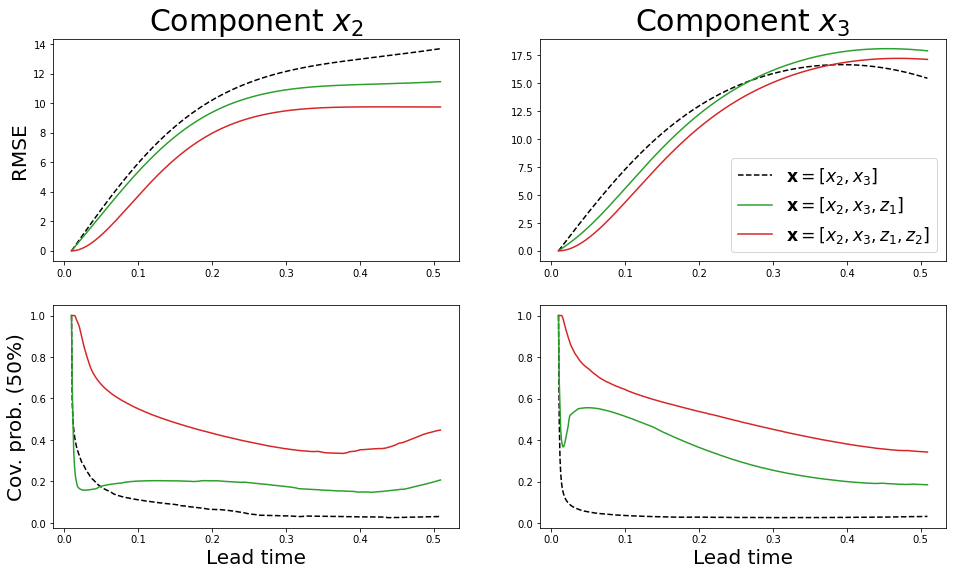

In [98]:
# plot RMSE ~ horizon for x2
subplot(2,2,1)
plot(t[0:horizon], tab_RMSE_V0_x2, 'k--')
plot(t[0:horizon], tab_RMSE_V1_x2, 'C2')
plot(t[0:horizon], tab_RMSE_V2_x2, 'C3')
#xlabel('Horizon', size=20)
ylabel('RMSE', size=20)
title('Component $x_2$', size=30)

# plot RMSE ~ horizon for x3
subplot(2,2,2)
plot(t[0:horizon], tab_RMSE_V0_x3, 'k--')
plot(t[0:horizon], tab_RMSE_V1_x3, 'C2')
plot(t[0:horizon], tab_RMSE_V2_x3, 'C3')
#xlabel('Horizon', size=20)
#ylabel('RMSE', size=20)
legend(['$\mathbf{x} = [x_2, x_3]$', '$\mathbf{x} = [x_2, x_3, z_1]$', '$\mathbf{x} = [x_2, x_3, z_1, z_2]$'],
       loc=0, fontsize='xx-large')
title('Component $x_3$', size=30)

# plot cov_prob ~ horizon for x2
subplot(2,2,3)
plot(t[0:horizon], tab_cov_prob_V0_x2, 'k--')
plot(t[0:horizon], tab_cov_prob_V1_x2, 'C2')
plot(t[0:horizon], tab_cov_prob_V2_x2, 'C3')
#plot([t[0], t[horizon]], [0.5, 0.5], 'k--')
xlabel('Lead time', size=20)
ylabel('Cov. prob. (50%)', size=20)

# plot cov_prob ~ horizon for x3
subplot(2,2,4)
plot(t[0:horizon], tab_cov_prob_V0_x3, 'k--')
plot(t[0:horizon], tab_cov_prob_V1_x3, 'C2')
plot(t[0:horizon], tab_cov_prob_V2_x3, 'C3')
#plot([t[0], t[horizon]], [0.5, 0.5], 'k--')
xlabel('Lead time', size=20)
#ylabel('Cov. prob. (50%)', size=20)

#savefig('/home/administrateur/Dropbox/Documents/Figures/Kalman/L63_RMSE_cov_prob.png', bbox_inches='tight', dpi=400)

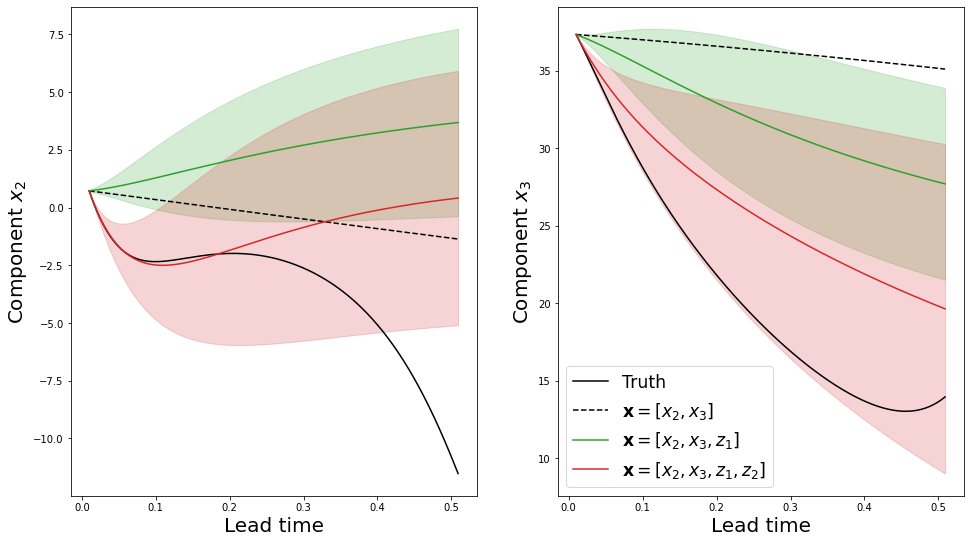

In [100]:
start_forecast = 4500
subplot(1,2,1)
plot(t[0:horizon], x_true[start_forecast,:,1], 'k')
plot(t[0:horizon], x_for_V0[start_forecast,:,0], 'k--')
plot(t[0:horizon], x_for_V1[start_forecast,:,0], 'C2')
plot(t[0:horizon], x_for_V2[start_forecast,:,0], 'C3')
fill_between(t[0:horizon], x_for_V1[start_forecast,:,0] - 0.64 * sqrt(P_for_V1[start_forecast,:,0,0]), x_for_V1[start_forecast,:,0] + 0.64 * sqrt(P_for_V1[start_forecast,:,0,0]), alpha=0.2, color='C2')
fill_between(t[0:horizon], x_for_V2[start_forecast,:,0] - 0.64 * sqrt(P_for_V2[start_forecast,:,0,0]), x_for_V2[start_forecast,:,0] + 0.64 * sqrt(P_for_V2[start_forecast,:,0,0]), alpha=0.2, color='C3')
ylabel('Component $x_2$', size=20)
xlabel('Lead time', size=20)
subplot(1,2,2)
plot(t[0:horizon], x_true[start_forecast,:,2], 'k')
plot(t[0:horizon], x_for_V0[start_forecast,:,1], 'k--')
plot(t[0:horizon], x_for_V1[start_forecast,:,1], 'C2')
plot(t[0:horizon], x_for_V2[start_forecast,:,1], 'C3')
fill_between(t[0:horizon], x_for_V1[start_forecast,:,1] - 0.64 * sqrt(P_for_V1[start_forecast,:,1,1]), x_for_V1[start_forecast,:,1] + 0.64 * sqrt(P_for_V1[start_forecast,:,1,1]), alpha=0.2, color='C2')
fill_between(t[0:horizon], x_for_V2[start_forecast,:,1] - 0.64 * sqrt(P_for_V2[start_forecast,:,1,1]), x_for_V2[start_forecast,:,1] + 0.64 * sqrt(P_for_V2[start_forecast,:,1,1]), alpha=0.2, color='C3')
ylabel('Component $x_3$', size=20)
xlabel('Lead time', size=20)
#suptitle('Statistical forecasts using linear operators', size=30)
legend(['Truth', '$\mathbf{x} = [x_2, x_3]$', '$\mathbf{x} = [x_2, x_3, z_1]$', '$\mathbf{x} = [x_2, x_3, z_1, z_2]$'],
       loc=0, fontsize='xx-large')

#savefig('/home/administrateur/Dropbox/Documents/Figures/Kalman/L63_example_forecast.png', bbox_inches='tight', dpi=400)